# N-Grams and Trends

how can we look at trends over time?

Google (and others) made n-gram viewers popular: LINK NGRAM VIEWER

we can try to do something similar to observe trends.

## Get Some Data

In [1]:
from cdp_data import CDPInstances, datasets

df = datasets.get_session_dataset(
    CDPInstances.Seattle,
    start_datetime="2020-01-01",
    end_datetime="2023-01-01",
    store_transcript=True,
    store_transcript_as_csv=True,
    raise_on_error=False,
)
df.columns, df.shape

Fetching each model attached to event_ref:   0%|          | 0/563 [00:00<?, ?it/s]

Fetching transcripts:   0%|          | 0/563 [00:00<?, ?it/s]

Converting transcripts:   0%|          | 0/563 [00:00<?, ?it/s]

(Index(['session_datetime', 'session_index', 'session_content_hash',
        'video_uri', 'video_start_time', 'video_end_time', 'caption_uri',
        'external_source_id', 'id', 'key', 'event', 'transcript',
        'transcript_path', 'transcript_as_csv_path'],
       dtype='object'),
 (563, 14))

# How to Count Words

Lets use a single transcript for an example.

In [2]:
import pandas as pd

example_session = pd.read_csv(df.iloc[0].transcript_as_csv_path)
example_session

,index,confidence,start_time,end_time,text,speaker_index,speaker_name,annotations
0,0,0.97,196.696,212.545,"Be discussing that in the, AME central staff.",0,NaN,NaN
1,1,0.97,212.545,217.917,Are you anticipating discussion on this piece ...,1,NaN,NaN
2,2,0.97,217.917,231.464,We are hoping to have it put on as soon as pos...,2,NaN,NaN
3,3,0.97,231.464,239.973,Obviously it's not just about this winter but ...,2,NaN,NaN
4,4,0.97,239.973,245.845,But we would like to so we hope that on the 28...,2,NaN,NaN
...,...,...,...,...,...,...,...,...
96,96,0.97,1293.191,1295.894,The purpose of the executive session is to dis...,15,NaN,NaN
97,97,0.97,1295.894,1300.298,The councils executive sessions are an opportu...,15,NaN,NaN
98,98,0.97,1300.298,1309.274,Illegal monitor for the city attorney's office...,15,NaN,NaN
99,99,0.97,1309.274,1320.819,I expect the executive session to end by--end ...,15,NaN,NaN


### Scikit Learn Count Vectorizer

If we want to track word counts over time, what we want is a large matrix of events and counts

Sort of like so:

| session_id | session_datetime | word | count |
|:-----------|:-----------------|:-------|:----|
| abcd-1234  | 2020-01-01       | hello  | 4   |
| abcd-1234  | 2020-01-01       | world  | 2   |
| ...        | ...              | ...    | ... |
| abcd-1234  | 2020-01-01       | ramen  | 2   |

Scikit Learn (`sklearn`) has a function to make that somewhat simple. We just need to combine all of the text for a single session into a single string.

In [3]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
all_session_text = " ".join(example_session.text)
counts = vectorizer.fit_transform([all_session_text])
vectorizer.get_feature_names_out()[:20]

array(['00', '10', '13', '14', '167', '2019', '2020', '2021', '22',
       '28th', '30', '36', '40', '630', 'able', 'about', 'absence',
       'acquiring', 'across', 'act'], dtype=object)

## Words?

The `CountVectorizer` includes all text, so we can see that some of the items counted were numbers and some were words. If we wanted to see their counts we can combine them.

Looks like "able" and "about" were both used 12 and 11 times respectively. Let's do this counting process for all of the meetings and store the data to a dataframe.

In [4]:
for word, count in zip(
    vectorizer.get_feature_names_out()[:20],
    list(counts[0, :20].toarray()[0]),
):
    print(f"'{word}' was used {count} times in the meeting")

'00' was used 2 times in the meeting
'10' was used 1 times in the meeting
'13' was used 3 times in the meeting
'14' was used 1 times in the meeting
'167' was used 1 times in the meeting
'2019' was used 1 times in the meeting
'2020' was used 5 times in the meeting
'2021' was used 1 times in the meeting
'22' was used 1 times in the meeting
'28th' was used 1 times in the meeting
'30' was used 4 times in the meeting
'36' was used 3 times in the meeting
'40' was used 1 times in the meeting
'630' was used 1 times in the meeting
'able' was used 12 times in the meeting
'about' was used 11 times in the meeting
'absence' was used 1 times in the meeting
'acquiring' was used 1 times in the meeting
'across' was used 1 times in the meeting
'act' was used 1 times in the meeting


## Pass In All Documents At Once

In [5]:
texts = []
for i, row in df.iterrows():
    session_transcript = pd.read_csv(row.transcript_as_csv_path)
    try:
        texts.append({
            "session_id": row.id,
            "session_datetime": row.session_datetime,
            "session_text": " ".join(session_transcript.text),
        })
    except:
        pass

text_df = pd.DataFrame(texts)
text_df

,session_id,session_datetime,session_text
0,4a7acf91fd3a,2020-01-06 17:30:00+00:00,"Be discussing that in the, AME central staff. ..."
1,60c31f54e81b,2020-01-06 22:00:00+00:00,Good afternoon everybody. Welcome to the Janua...
2,65b686462f92,2020-01-07 17:30:00+00:00,"I am joined by several colleagues, council mem..."
3,0efe5623841f,2020-01-13 17:30:00+00:00,Good morning. This is the Council briefing mee...
4,aa7e64fbfff8,2020-01-15 17:30:00+00:00,"Good morning, everybody. I'm Councilmember Ale..."
...,...,...,...
472,4d5bb0e3a2e7,2022-09-12 21:00:00+00:00,"Thank you, good afternoon. Today is Monday, Se..."
473,415b06af6e18,2022-09-13 16:30:00+00:00,Not all of you Unmetered your microphones. We ...
474,d87f8f396ebf,2022-09-14 16:30:00+00:00,"Good morning. The September 14, 2022 meeting o..."
475,e9bdfa228805,2022-10-03 21:00:00+00:00,"& GT; With that, good afternoon, everyone . to..."


In [6]:
vectorizer = CountVectorizer()
counts = vectorizer.fit_transform(text_df.session_text)
count_df = pd.DataFrame(counts.toarray(), columns=vectorizer.get_feature_names_out())
count_df["session_id"] = text_df["session_id"]
count_df["session_datetime"] = text_df["session_datetime"]
count_df

,00,000,0000,000000,0001,0002,000as,000ed,000s,000th,...,úwords,úwork,úworking,úwould,úyears,úyou,úyour,시간,session_id,session_datetime
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4a7acf91fd3a,2020-01-06 17:30:00+00:00
1,3,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,60c31f54e81b,2020-01-06 22:00:00+00:00
2,0,15,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,65b686462f92,2020-01-07 17:30:00+00:00
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0efe5623841f,2020-01-13 17:30:00+00:00
4,2,14,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,aa7e64fbfff8,2020-01-15 17:30:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
472,4,8,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4d5bb0e3a2e7,2022-09-12 21:00:00+00:00
473,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,415b06af6e18,2022-09-13 16:30:00+00:00
474,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,d87f8f396ebf,2022-09-14 16:30:00+00:00
475,20,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,e9bdfa228805,2022-10-03 21:00:00+00:00


In [7]:
count_df = count_df.melt(id_vars=["session_id", "session_datetime"], var_name="word", value_name="word_count")
count_df

,session_id,session_datetime,word,word_count
0,4a7acf91fd3a,2020-01-06 17:30:00+00:00,00,2
1,60c31f54e81b,2020-01-06 22:00:00+00:00,00,3
2,65b686462f92,2020-01-07 17:30:00+00:00,00,0
3,0efe5623841f,2020-01-13 17:30:00+00:00,00,0
4,aa7e64fbfff8,2020-01-15 17:30:00+00:00,00,2
...,...,...,...,...
22670374,4d5bb0e3a2e7,2022-09-12 21:00:00+00:00,시간,0
22670375,415b06af6e18,2022-09-13 16:30:00+00:00,시간,0
22670376,d87f8f396ebf,2022-09-14 16:30:00+00:00,시간,0
22670377,e9bdfa228805,2022-10-03 21:00:00+00:00,시간,0


## Most Common Words (Average Across All Meetings)

Filler words are the most common

In [8]:
count_df.groupby("word")["word_count"].mean().nlargest(20)

word
the     770.329140
to      528.911950
and     450.784067
of      329.976939
that    324.733753
we      250.761006
in      222.574423
is      213.989518
you     191.482180
for     182.062893
this    146.102725
on      134.119497
are     131.031447
it      130.354298
have    126.163522
with    100.635220
be       97.268344
as       96.113208
will     92.855346
so       89.000000
Name: word_count, dtype: float64

## Plotting

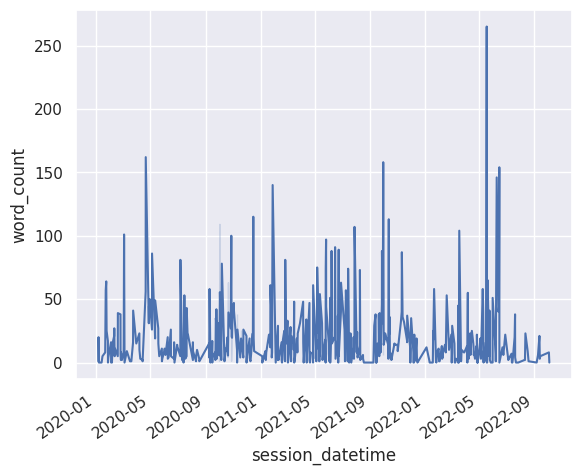

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="darkgrid")

# Select the word we are interested in
housing_counts = count_df[count_df["word"] == "housing"]

# Plot the responses for different events and regions
sns.lineplot(
    x="session_datetime",
    y="word_count",
    data=housing_counts,
)
_ = plt.xticks(rotation=35, ha="right")

## Why Is This Deceptive?

1. Meetings are different length. One meeting might be longer and therefore have more words overall.
2. Discussion doesn't happen every day. Need to smooth it out somehow.
3. "Housing" doesn't include "house", "houses", etc.

## Possible Solution: Make Each Word Count a "Percentage" of Total Words for The Meeting

In [10]:
count_df["percent_use_in_meeting"] = count_df["word_count"] / count_df.groupby("session_id")["word_count"].transform("sum")
count_df

,session_id,session_datetime,word,word_count,percent_use_in_meeting
0,4a7acf91fd3a,2020-01-06 17:30:00+00:00,00,2,0.000719
1,60c31f54e81b,2020-01-06 22:00:00+00:00,00,3,0.000256
2,65b686462f92,2020-01-07 17:30:00+00:00,00,0,0.000000
3,0efe5623841f,2020-01-13 17:30:00+00:00,00,0,0.000000
4,aa7e64fbfff8,2020-01-15 17:30:00+00:00,00,2,0.000162
...,...,...,...,...,...
22670374,4d5bb0e3a2e7,2022-09-12 21:00:00+00:00,시간,0,0.000000
22670375,415b06af6e18,2022-09-13 16:30:00+00:00,시간,0,0.000000
22670376,d87f8f396ebf,2022-09-14 16:30:00+00:00,시간,0,0.000000
22670377,e9bdfa228805,2022-10-03 21:00:00+00:00,시간,0,0.000000


## Replot

Interpret: The y-axis is now "percent usage of this word in each session" i.e. if the value is ~0.01 that means that the word was used 1% of the time (or about 1/100 words used in the meeting was "housing").

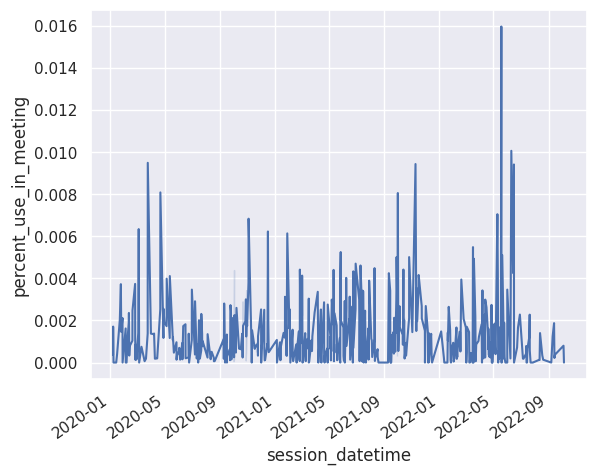

In [11]:
# Select the word we are interested in
housing_counts = count_df[count_df["word"] == "housing"]

# Plot the responses for different events and regions
sns.lineplot(
    x="session_datetime",
    y="percent_use_in_meeting",
    data=housing_counts,
)
_ = plt.xticks(rotation=35, ha="right")

## Possible Solution: Rolling Mean Over One Month

In [12]:
rolling_30_days = count_df.set_index("session_datetime").sort_index(ascending=True).groupby("word").rolling("30D").agg({
    "percent_use_in_meeting": "mean"
}).reset_index()
rolling_30_days

,word,session_datetime,percent_use_in_meeting
0,00,2020-01-06 17:30:00+00:00,0.000719
1,00,2020-01-06 22:00:00+00:00,0.000488
2,00,2020-01-07 17:30:00+00:00,0.000325
3,00,2020-01-13 17:30:00+00:00,0.000244
4,00,2020-01-15 17:30:00+00:00,0.000227
...,...,...,...
22670374,시간,2022-09-12 21:00:00+00:00,0.000000
22670375,시간,2022-09-13 16:30:00+00:00,0.000000
22670376,시간,2022-09-14 16:30:00+00:00,0.000000
22670377,시간,2022-10-03 21:00:00+00:00,0.000000


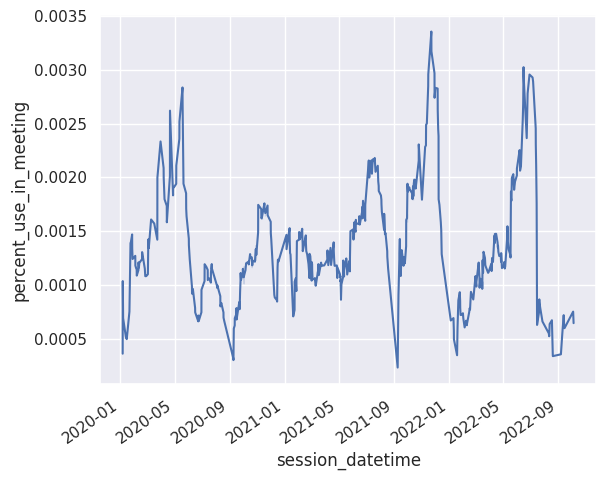

In [13]:
# Select the word we are interested in
housing_counts = rolling_30_days[rolling_30_days["word"] == "housing"]

# Plot the responses for different events and regions
sns.lineplot(
    x="session_datetime",
    y="percent_use_in_meeting",
    data=housing_counts,
)
_ = plt.xticks(rotation=35, ha="right")

## Possible Solution: Stem Each Word Prior to Counting

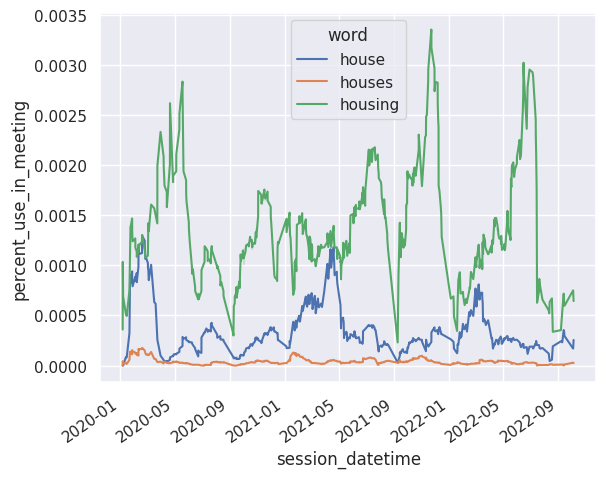

In [14]:
# Select the word we are interested in
housing_counts = rolling_30_days[rolling_30_days["word"].isin(["housing", "house", "houses"])]

# Plot the responses for different events and regions
sns.lineplot(
    x="session_datetime",
    y="percent_use_in_meeting",
    hue="word",
    data=housing_counts,
)
_ = plt.xticks(rotation=35, ha="right")